# MNIST classification using Variational Quantum Classifier


* **Author**: yeray142 (Yeray C.)
* **Date**: 2023/09/16
* **Version**: 1.0
* **Description**: Variational Quantum Classifier model applied to MNIST dataset.

## Setup

In [86]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

## Part 1 - Data preprocessing

### Importing MNIST dataset

In [87]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


### Flattening the images to 1D array

In [88]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
print(x_train_flattened.shape)

(60000, 784)


### Standardizing data

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_flattened_standardize = scaler.fit_transform(x_train_flattened)

### Dimensionality reduction

Since we are going to use TSNE, which scales extremely slowly with large datasets, we are going to use a sample of just 10000 instances for study purpose.

In [90]:
X_train = pd.DataFrame(x_train_flattened_standardize)
X_train['label'] = y_train
X = X_train.sample(n=10000, random_state=42)

y_train = X['label']
X_train = X.drop('label', axis = 1)

We will combine PCA + TSNE to gain advantage of the fast execution of PCA and the good performance of TSNE. As you can see [here](https://www.kaggle.com/code/pranaysingh25/dimensionality-reduction-visualization-mnist).

22.358712911605835


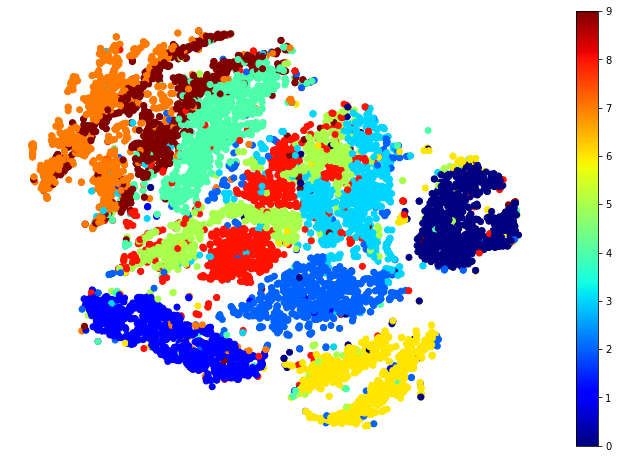

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('tsne', TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne = pca_tsne.fit_transform(X_train)
t1 = time.time()
print(t1-t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_pca_tsne[:,0], X_pca_tsne[:,1], c = y_train, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

In [92]:
X_pca_tsne.shape

(10000, 2)

### Feature scaling

In [93]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [94]:
from sklearn.preprocessing import MinMaxScaler

X_filtered, y_filtered = filter_36(X_pca_tsne, y_train)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_filtered)
X_train.shape

(1981, 2)

### Train-test splitting

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_filtered, test_size=.2)

## Part 2 - Model training

### Feature map

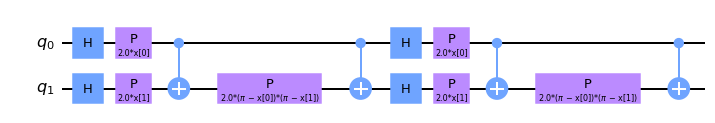

In [96]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2)
feature_map.decompose().draw(output="mpl", fold=30)

### Ansatz circuit

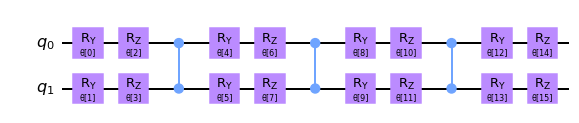

In [97]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(X_train.shape[1], ['ry', 'rz'], 'cz', reps=3)
ansatz.decompose().draw(output="mpl", fold=30)

### Optimization Algorithm

In [98]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

### Define callback function

In [99]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Training model on train dataset

In [100]:
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)
y_train = y_train.values

,label
21018,True
52751,True
29620,False
59001,True
26516,False
...,...
38511,False
52688,False
770,False
28406,True


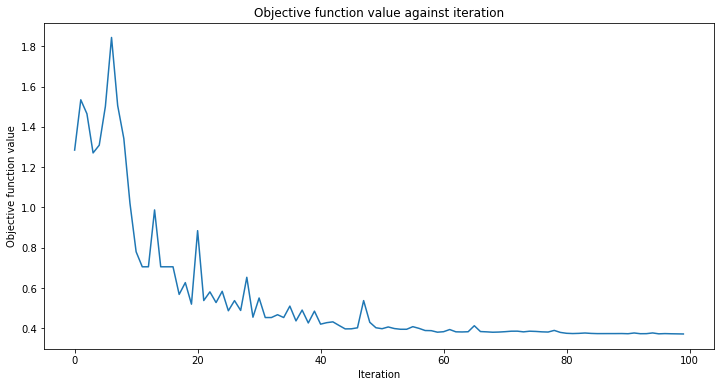

Training time: 971 seconds


In [107]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Part 4 - Testing on test dataset and evaluating model

In [108]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)
y_test = y_test.values

In [109]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

y_pred = vqc.predict(X_test)
print(y_pred)

Quantum VQC on the training dataset: 0.95
Quantum VQC on the test dataset:     0.97
[False  True False  True False  True False False False False  True False
 False  True False False False  True False False False  True  True  True
 False  True  True  True  True  True False False  True  True  True  True
 False  True  True  True  True  True  True  True False  True  True False
  True  True False  True False False False  True False  True  True False
  True False  True False  True  True False False False False  True False
 False  True  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True False  True False False  True  True
 False False  True False  True False False False False False  True False
 False  True False  True  True  True False  True False  True  True  True
  True False False False  True  True  True False False  True False  True
  True False  True False  True  True  True False False  True False False
  True  True  True False False  True  Tr

As we can see, the accuracy of our model on the test dataset is of about **97%**, which is a perfect result.

In [111]:
import qiskit.tools.jupyter
%qiskit_version_table